### imports and initializations

In [76]:
%load_ext autoreload
%autoreload 2
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.simfunc.simulation import Simulation  # class for simulation
from src.utils.simparam import SimParam  # class for simulation parameters
from src.utils.utils import day_graph, minutes_to_hms

%matplotlib inline
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Section 1

## Pre processing of busy day schedule

In [78]:
years = [2023, 2024, 2025, 2026]
dct_data = {
    year: pd.read_excel(
        f"/home/antoine/projects/pax-flow-sim/data/raw/FY{year} KIX schedule"
        " forecast.xlsx",
        sheet_name="ALLdata",
        header=1,
    )
    for year in years
}
dct_data_processed = {}
dct_simparam = {}

# table should be formatted with following columns
# | A/D | T1/T2(MM/9C/7C/TW) | Intl Regions | Category(P/C/O) | Sector |
# | Flight Number | SEATS FC | PAX_SUM FC | Flight Date | Scheduled Time |

for key, data in dct_data.items():
    data["T1/T2(MM/9C/7C/TW)"] = data["Terminal"].replace(
        {"N": "T1", "S": "T1", 1: "T1", "L": "T2", np.nan: "-"}
    )

    data["Category(P/C/O)"] = data["Flight Type"].apply(lambda x: x[0])

    dct_name_change = {
        "Int / Dom": "Sector",
        "Int P Region": "Intl Regions",
        "Fight Number": "Flight Number",  # <- to be split with space between letters and digits
        "Seats": "SEATS FC",
        "PAX": "PAX_SUM FC",
        "Date": "Flight Date",
        "Time": "Scheduled Time",
    }

    dct_data_processed[key] = data.rename(columns=dct_name_change)

## Scenario 1 - no CU

In [79]:
# really, we need to select busiest day of each year
# and let's plot on a single graph
for key, data_processed in dct_data_processed.items():
    dct_simparam[key] = SimParam()
    dct_simparam[key].schedule_from_df(
        data_processed
    ).schedule_cleanup().schedule_filter(date_str=f"{key}-12-20").assign_check_in()

### std graph

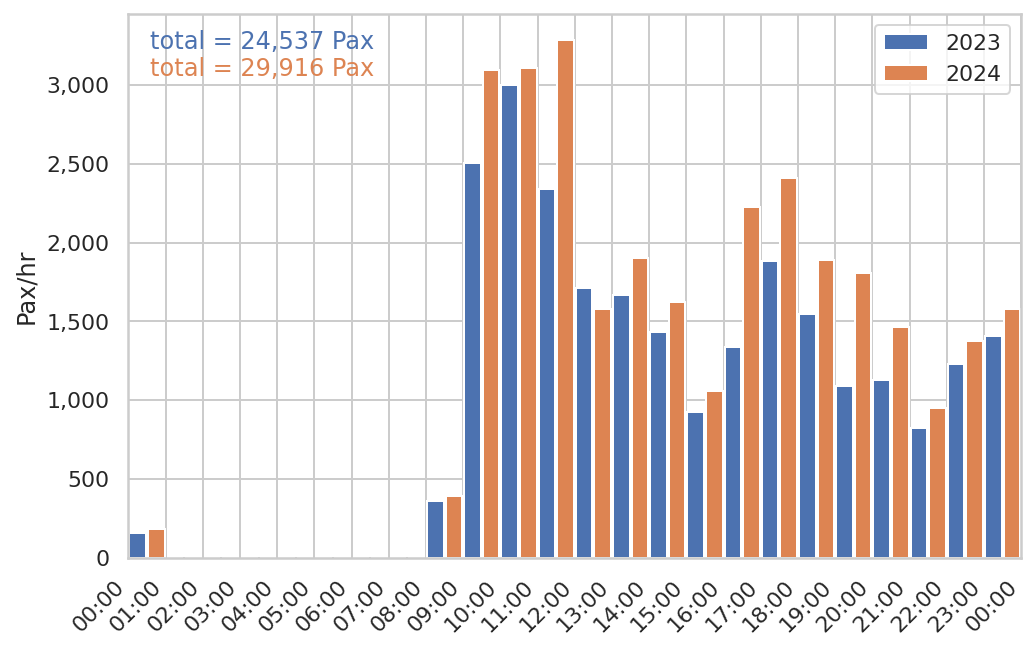

In [80]:
dct_simparam[2023].plot_std(compare_with=dct_simparam[2024])

### counter graph

In [ ]:
dct_simparam[2024].plot_counters(airlines=["total"], compare_with=dct_simparam[2023])

### demo of graph functions

In [ ]:
dct_simparam[2024].plot_counters(
    airlines=dct_simparam[2024].df_Counters.drop("total", axis=1).columns.to_list(),
)

In [ ]:
dct_simparam[
    2023
].show_up_from_file().assign_flight_show_up_category_default().assign_show_up()
dct_simparam[
    2024
].show_up_from_file().assign_flight_show_up_category_default().assign_show_up()

In [ ]:
dct_simparam[2023].df_Pax.loc[:5000, "pax_type"] = "type1"
dct_simparam[2023].df_Pax.loc[5000:, "pax_type"] = "type2"

dct_simparam[2024].df_Pax.loc[:10000, "pax_type"] = "type1"
dct_simparam[2024].df_Pax.loc[10000:, "pax_type"] = "type2"


dct_simparam[2023].plot_df_Pax(by_pax_type=True, compare_with=dct_simparam[2024])

## Scenario 1 - with CU

### airline selection

In [ ]:
simparam = dct_simparam[2023]
simparam_tradi = deepcopy(simparam)

In [ ]:
all_airlines = simparam.df_Counters.iloc[:, :-1].sum(axis=0).index.to_list()
airlines = simparam.df_Counters.loc[85:125, :].sum(axis=0).index.to_list()[-20:-1]

airlines_CU = airlines + ["AF"]
airlines_tradi = [x for x in all_airlines if x not in airlines_CU]
mask_airlines_CU = simparam.schedule["Airline Code"].isin(airlines_CU)

simparam_tradi = deepcopy(simparam)
simparam_tradi.schedule = simparam_tradi.schedule[mask_airlines_CU == False].copy()
simparam_tradi.assign_check_in()

print(f"max used tradi counters = {simparam_tradi.df_Counters['total'].max()}")
simparam_tradi.plot_counters(airlines=["total"], compare_with=simparam, legend=False)

### simulation of waiting times

In [ ]:
simparam.dct_resource = {
    "kiosk": 92,
    "CUSBD": 14,
}

simparam.dct_processes = {
    "kiosk": 70,
    "CUSBD": 80,
    "checkin": 80,
}

simparam.dct_process_sequence = {
    "tradi": [
        ["kiosk", "wait_opening", "checkin"],
        {"hour_to_std": 2.5},
    ],
    "CUSBD": [
        ["kiosk", "wait_opening", "CUSBD"],
        {"hour_to_std": 2.5},
    ],
}

mask_CUSBD_pax = simparam.df_Pax["Airline"].isin(airlines_CU)

mask_tradi = mask_CUSBD_pax == False
simparam.df_Pax.loc[mask_CUSBD_pax, "pax_type"] = "CUSBD"
simparam.df_Pax.loc[mask_tradi, "pax_type"] = "tradi"

In [ ]:
freq = "1H"
win = 1
ratio_sampling = pd.to_timedelta("1H") / pd.to_timedelta(freq)

plot_CU = (
    simparam.schedule[mask_airlines_CU]
    .set_index("Scheduled Time", drop=False)["PAX_SUM FC"]
    .resample(freq)
    .agg(["sum"])
    .rolling(window=win, center=True)
    .mean()
    .dropna()
    .apply(lambda x: x * ratio_sampling)
)

plot_tradi = (
    simparam.schedule[(mask_airlines_CU == False)]
    .set_index("Scheduled Time", drop=False)["PAX_SUM FC"]
    .resample(freq)
    .agg(["sum"])
    .rolling(window=win, center=True)
    .mean()
    .dropna()
    .apply(lambda x: x * ratio_sampling)
)

In [ ]:
plot_CU = plot_CU.reindex_like(plot_tradi).fillna(0).copy()
fig, ax = day_graph()

nbar = 1

colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
nb_bar = 1
# plot param
width_hour = pd.Timedelta("0 days 01:00:00")
width_bar = 0.7 * width_hour / nb_bar
width = width_bar


label = "tradi"
x = plot_tradi.index + pd.Timedelta("0 days 00:30:00")
ax.bar(
    x=x,
    height=plot_tradi["sum"],
    width=width,
    align="center",
    color=colors[0],
    label=label,
)
ax.text(
    0.15,
    0.90,
    f"{int(plot_tradi['sum'].sum()):,} Pax {label}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    color=colors[0],
)


label = "CU"
ax.bar(
    x=x,
    height=plot_CU["sum"],
    bottom=plot_tradi["sum"],
    width=width,
    align="center",
    color=colors[1],
    label=label,
)
ax.text(
    0.15,
    0.95,
    f"{int(plot_CU['sum'].sum()):,} Pax {label}",
    horizontalalignment="center",
    verticalalignment="center",
    transform=ax.transAxes,
    color=colors[1],
)


plt.show()

In [ ]:
simulation2023 = Simulation(simparam)
simulation2023.generate_checkin().generate_pax()
simulation2023.run()
simulation2023.format_df_result().plot_result()

### If early CU opening

In [2]:
simulation2023_early_CU = Simulation(simparam)

simulation2023_early_CU.simparam.dct_process_sequence = {
    "tradi": [
        ["kiosk", "wait_opening", "checkin"],
        {"hour_to_std": 2.5},
    ],
    "CUSBD": [
        ["kiosk", "wait_opening", "CUSBD"],
        {"hour_to_std": 3.5},
    ],
}

simulation2023_early_CU.generate_checkin().generate_pax()
simulation2023_early_CU.run()

simulation2023_early_CU.format_df_result().plot_result()

NameError: name 'simparam' is not defined

# Section 2

## Scenario 2 - no CU

### std graph

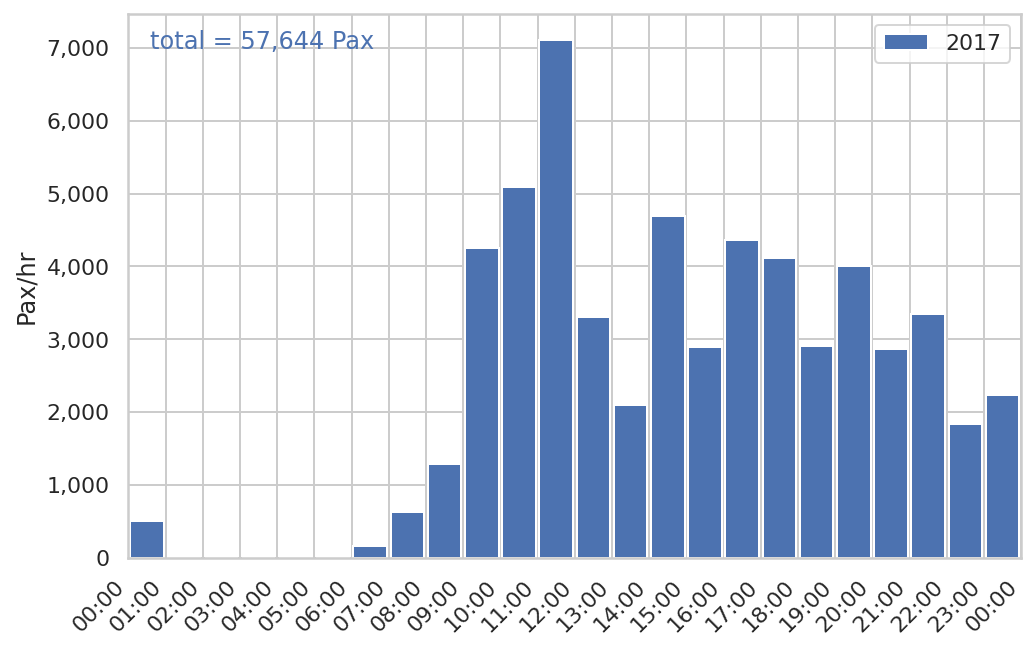

In [81]:
simparam = SimParam()
path_to_6k_sched = (
    r"/home/antoine/projects/pax-flow-sim/data/processed/Schedule (30th terminal"
    r" peak, 6000 pax)_PROCESSED.xlsx"
)
simparam.schedule_from_path(path_to_6k_sched)
simparam.schedule_cleanup().schedule_filter().assign_check_in()
simparam.plot_std()

In [3]:
simparam2 = deepcopy(simparam)
simparam2.assign_check_in(
    start_time=3.5,
    onecounter_time=0.75,
    base_n_counter=3,
    seats_per_add_counter=100,
)

In [7]:
simparam.df_Counters["total"].sum(axis=0)

27482

In [8]:
simparam2.df_Counters["total"].sum(axis=0)

28254

### counter graph

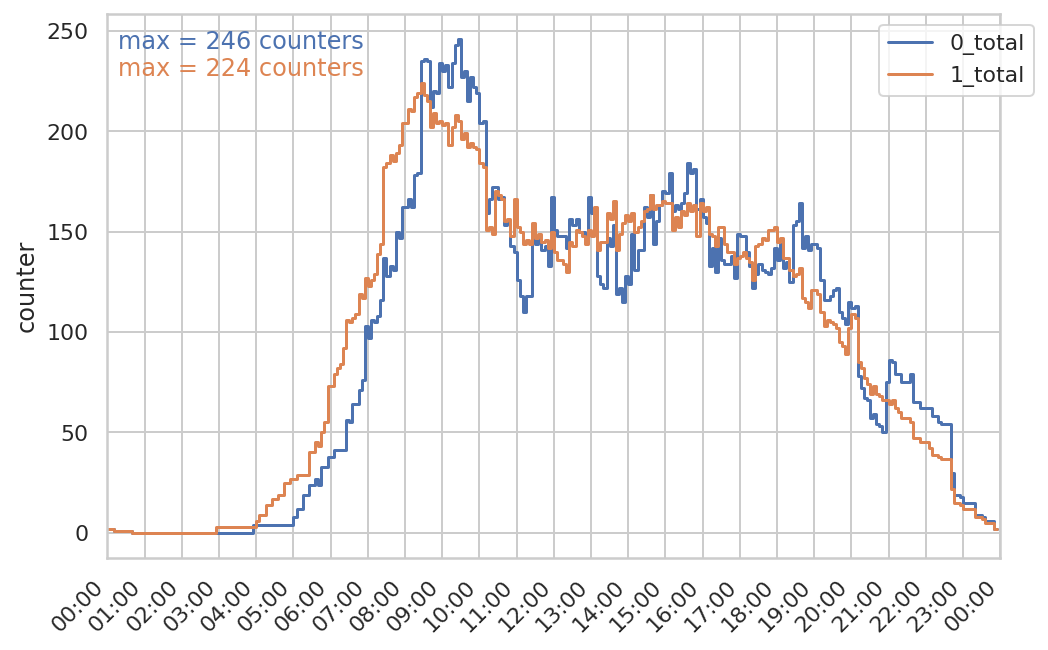

In [9]:
simparam.plot_counters(compare_with=simparam2)

## Scenario 2 - with CU

### Airline selection

In [82]:
simparam_tradi = deepcopy(simparam)
airlines = [
    "ANA",
    "KAL",
    "CPA",
    "SIA",
    "JNA",
    "AAR",
    "HVN",
    "JJA",
    "CES",
    "CAL",
    "EVA",
    "CSN",
    "THA",
    "DAL",
    "HKE",
    "GCR",
    "MAS",
    "TTW",
    "CDG",
]
mask_airlines = simparam_tradi.schedule["Airline Code"].isin(airlines)
simparam_tradi.schedule = simparam_tradi.schedule[mask_airlines == False].copy()
simparam_tradi.schedule_cleanup().schedule_filter().assign_check_in()

In [83]:
simparam_tradi2 = deepcopy(simparam_tradi)
simparam_tradi2.assign_check_in(
    start_time=3.5,
    onecounter_time=0.75,
    base_n_counter=3,
    seats_per_add_counter=100,
)

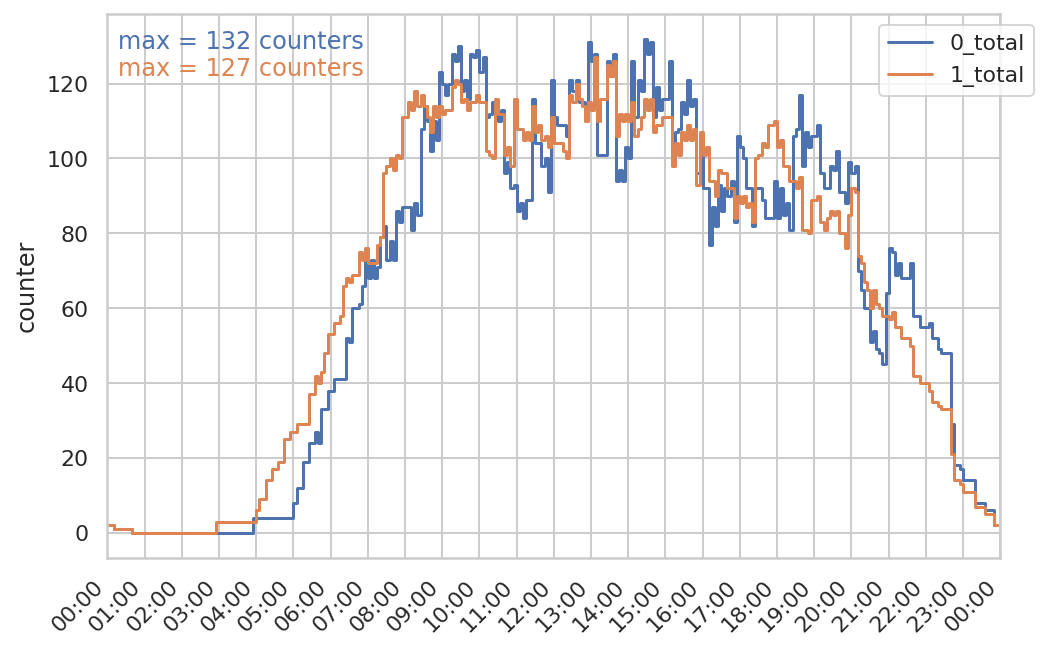

In [6]:
simparam_tradi.plot_counters(compare_with=simparam_tradi2)

max used tradi counters = 132


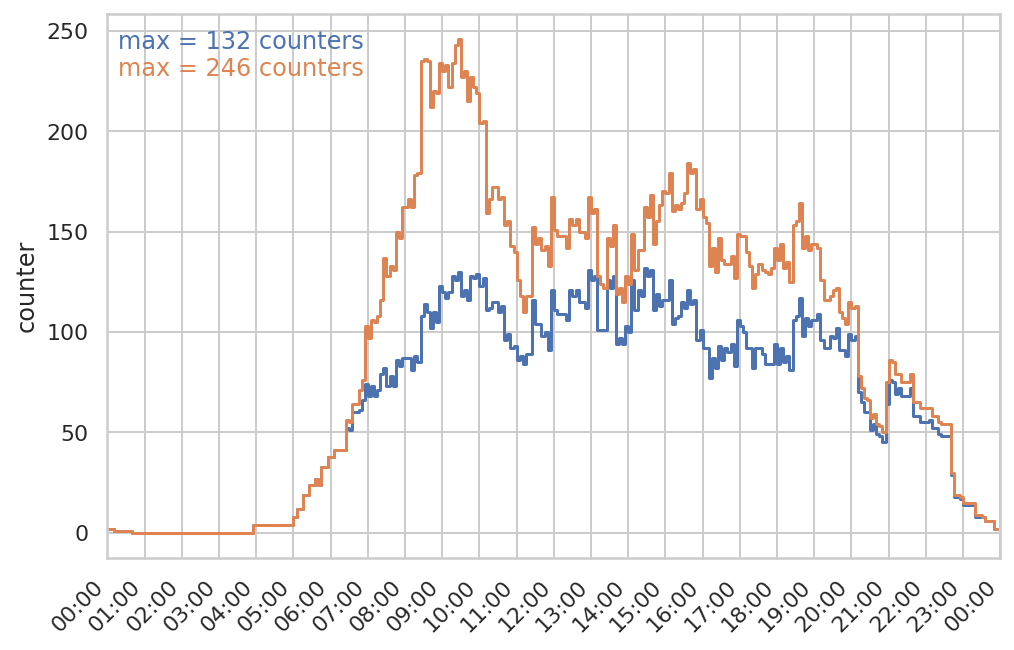

In [7]:
print(f"max used tradi counters = {simparam_tradi.df_Counters['total'].max()}")
simparam_tradi.plot_counters(airlines=["total"], compare_with=simparam, legend=False)

### simulation of waiting times

In [84]:
simparam.show_up_from_file().assign_flight_show_up_category_default().assign_show_up()

In [85]:
simparam.dct_resource = {
    "kiosk": 92,
    "CUSBD": 32,
}

simparam.dct_processes = {
    "kiosk": 70,
    "CUSBD": 60,
    "checkin": 80,
}

simparam.dct_process_sequence = {
    "tradi": [
        ["kiosk", "wait_opening", "checkin"],
        {"hour_to_std": 2.5},
    ],
    "CUSBD": [
        ["kiosk", "wait_opening", "CUSBD"],
        {"hour_to_std": 2.5},
    ],
}

mask_CUSBD_pax = simparam.df_Pax["Airline"].isin(airlines)

mask_tradi = mask_CUSBD_pax == False
simparam.df_Pax.loc[mask_CUSBD_pax, "pax_type"] = "CUSBD"
simparam.df_Pax.loc[mask_tradi, "pax_type"] = "tradi"

In [86]:
mask_cusbd_sched = simparam.schedule["Airline Code"].isin(airlines)
mask_tradi_sched = mask_cusbd_sched == False
simparam.schedule.loc[mask_cusbd_sched, "cusbd-tradi"] = "cusbd"
simparam.schedule.loc[mask_tradi_sched, "cusbd-tradi"] = "tradi"

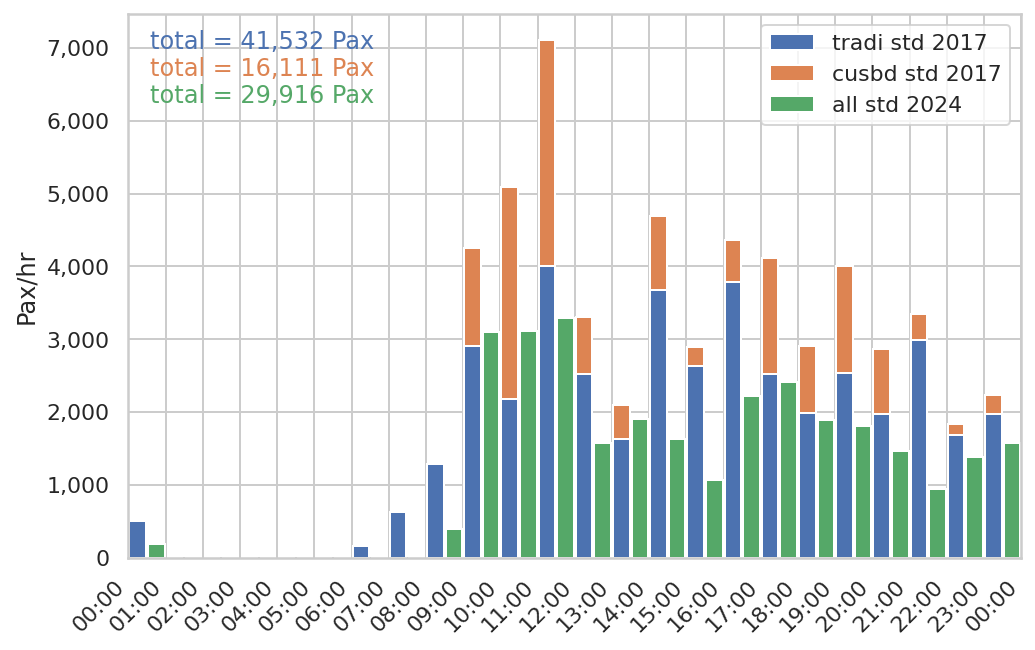

In [87]:
simparam.plot_std(by_col=True, col_name="cusbd-tradi", compare_with=dct_simparam[2024])

In [ ]:
simulation2060 = Simulation(simparam)
simulation2060.generate_checkin().generate_pax()
simulation2060.run()

In [ ]:
simulation2060.format_df_result().plot_result()

### If early CU opening

In [ ]:
simulation2060_early_CU = Simulation(simparam)

simulation2060_early_CU.simparam.dct_process_sequence = {
    "tradi": [
        ["kiosk", "wait_opening", "checkin"],
        {"hour_to_std": 2.5},
    ],
    "CUSBD": [
        ["kiosk", "wait_opening", "CUSBD"],
        {"hour_to_std": 3.5},
    ],
}

simulation2060_early_CU.generate_checkin().generate_pax()
simulation2060_early_CU.run()
simulation2060_early_CU.format_df_result().plot_result()

### If early CU opening

In [ ]:
simulation2023_early_CU = Simulation(simparam)

simulation2023_early_CU.simparam.dct_process_sequence = {
    "tradi": [
        ["kiosk", "wait_opening", "checkin"],
        {"hour_to_std": 2.5},
    ],
    "CUSBD": [
        ["kiosk", "wait_opening", "CUSBD"],
        {"hour_to_std": 3.5},
    ],
}

simulation2023_early_CU.generate_checkin().generate_pax()
simulation2023_early_CU.run()
simulation2023_early_CU.format_df_result().plot_result()